# Variance - Weighed average timestamp correlation

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [47]:
# Get the merged malware data
df = pd.read_csv("vt_reports/merge.csv")
df.head()

,sha256,first_submission_date,family
0,98f8e26e12b978102fa39c197f300ebe5fe535617737d5...,1630575593,tnega
1,7b2999ffadbc3b5b5c5e94145ca4e2f8de66ac1e3ddd52...,1629375559,quasar
2,e7569d494fe00be04ef6c9fcc5e54720c0df623b08e79d...,1362057319,pasta
3,1ed60c04f572b6acb9f64c31db55ef5c6b5465bd4da1eb...,1630624233,cjishu
4,4c4aaff20a57213d9a786e56ad22f1eaa94694a2f1042b...,1592186154,kingsoft


In [48]:
df_variances = pd.read_csv("variances.csv")
df_variances.head()

,Unnamed: 0,family,variance,families_perc
0,377,cobra,0.017703,0.001493
1,282,gendal,0.019088,0.004478
2,104,kiser,0.019088,0.004478
3,2,pasta,0.019434,0.007463
4,90,bestafera,0.019434,0.007463


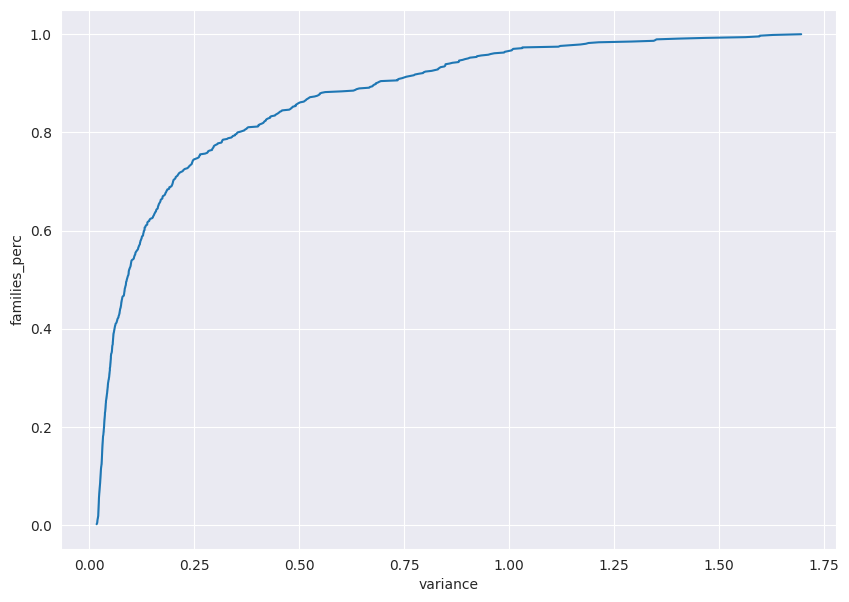

In [49]:
# Plot the distribution of first submissions over time
plt.figure(figsize=(10, 7))
sns.lineplot(df_variances, x="variance", y="families_perc")
plt.show()

In [50]:
df_variances = pd.DataFrame({"family": df_variances["family"], "variance": df_variances["variance"]})
df_variances_top = df_variances[df_variances["variance"] > 0.3].sort_values(by="variance", ascending=False)
families = df_variances_top["family"][:20]
df_variances_top.head()

,family,variance
669,balrok,1.696429
668,snojan,1.628920
667,griptolo,1.597762
666,stone,1.596723
665,daws,1.563488


In [51]:
# Extract the year from a timestamp t
def t_to_year(t):
    dt = pd.to_datetime(t, unit='s')
    return dt.year  #pd.Timestamp(f"{dt.year}-{dt.month}")


df_dt = df.copy()
df_dt['first_submission_date'] = df['first_submission_date'].apply(lambda t: t_to_year(t))

In [ ]:
year_min = df_dt["first_submission_date"].min()
year_max = df_dt["first_submission_date"].max()

years_range = range(year_min, year_max + 1)  #pd.date_range(start=year_min, end=year_max, freq="Y")
df_dt_1 = df_dt.groupby(by=["family", "first_submission_date"]).size().reset_index(name='count')

for family in families:
    year_count = np.zeros(len(years_range))
    # Get the dataset portion where family is equal to the iteration one.
    family_data = df_dt_1[df_dt_1["family"] == family]
    # From each date compute the offset relative to year_count
    off = [y - year_min for y in family_data["first_submission_date"]]
    # Set each off cell with the respective count
    for index, value in zip(off, family_data["count"]):
        year_count[index] = value

    df_plot = pd.DataFrame({"year": years_range, "count": year_count})
    plt.figure(figsize=(10, 7))
    sns.barplot(data=df_plot, x="year", y="count")
    plt.title(f"Family: {family}, "
              f"Variance: {df_variances_top[df_variances_top['family'] == family]['variance'].iloc[0]}")
    plt.show()

In [53]:
def t_to_date(t):
    dt = pd.to_datetime(t, unit='s')
    return pd.Timestamp(f"{dt.year}-{dt.month}-{dt.day}")


df_corr = df.copy()
df_corr["first_submission_date"] = df_corr["first_submission_date"].apply(lambda t: t_to_date(t))
df_corr_1 = df_corr.groupby(by=["family", "first_submission_date"]).size().reset_index(name='count')

In [54]:
from scipy.stats import pearsonr

w_avg_timestamps = []
families = df_variances["family"].unique()
for family in families:
    family_data = df_corr_1[df_corr_1["family"] == family]
    timestamps = family_data["first_submission_date"].apply(lambda dt: dt.timestamp())
    w_avg = np.average(timestamps, weights=family_data["count"])
    w_avg_timestamps.append(w_avg)

df_avg_timestamps_f = pd.DataFrame({"family": families, "w_avg_timestamp": w_avg_timestamps})
df_variances_f = df_variances[df_variances["family"].isin(families)]

df_var_wat = pd.merge(left=df_avg_timestamps_f, right=df_variances_f, on="family")

correlation = df_var_wat["variance"].corr(df_var_wat["w_avg_timestamp"])

print(pearsonr(df_var_wat["variance"], df_var_wat["w_avg_timestamp"]))

print(f"Variance-Weighted Avg Timestamp correlation: {correlation}")

PearsonRResult(statistic=0.46342968410931346, pvalue=5.630758111934565e-37)
Variance-Weighted Avg Timestamp correlation: 0.4634296841093138


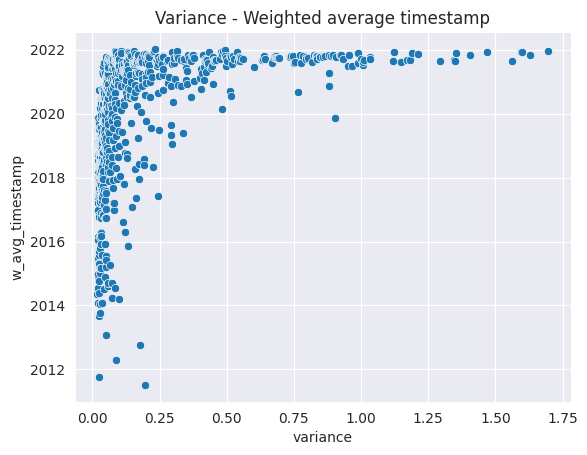

In [55]:
df_var_wat["w_avg_timestamp"] = df_var_wat["w_avg_timestamp"].apply(lambda t: pd.to_datetime(t, unit="s"))
sns.scatterplot(x=df_var_wat["variance"], y=df_var_wat["w_avg_timestamp"])
plt.title("Variance - Weighted average timestamp")
plt.show()

In [56]:
print(len(df_var_wat[df_var_wat["variance"] > 0.15]))
print(len(df_var_wat[df_var_wat["variance"] <= 0.15]))

252
418


In [95]:
def score(d, d_max):
    return ((np.power(np.e, -d) - np.power(np.e, -d_max)) /
            (1 - np.power(np.e, -d_max)))


def score_array_by_d(a, d, d_max):
    return np.array([score(np.abs((d - t).days), d_max) for t in a])


In [96]:
# Min and maximum dates
fsd = "first_submission_date"

df1 = df.copy()
df1['first_submission_date'] = (df['first_submission_date']
                                .apply(lambda t: pd.to_datetime(t, unit="s"))
                                .apply(lambda dt: pd.Timestamp(f"{dt.year}-{dt.month}-{dt.day}")))

# Get all the days between min and max
date_min, date_max = df1[fsd].min(), df1[fsd].max()
days_range = pd.date_range(start=date_min, end=date_max, freq='D').tolist()

In [102]:
df_f_min, df_f_max = (df1.groupby(by=["family"]).min(),
                      df1.groupby(by=["family"]).max())
d_max = (date_max - date_min).days
scores = []
for d in days_range:
    # Get the families that disappeared before d and will appear after d
    df_dis, df_app = df_f_max[df_f_max[fsd] <= d], df_f_min[df_f_min[fsd] > d]
    dis_app = np.concatenate([np.array(df_dis[fsd]), np.array(df_app[fsd])])
    # Compute the distance score
    scores.append(np.sum(score_array_by_d(dis_app, d, d_max)))

In [103]:
max_score_idx, max_score = np.argmax(scores), np.max(scores)

print(f"max score: {max_score} at day: {days_range[max_score_idx]}")

max score: 171.81669536527994 at day: 2021-12-27 00:00:00


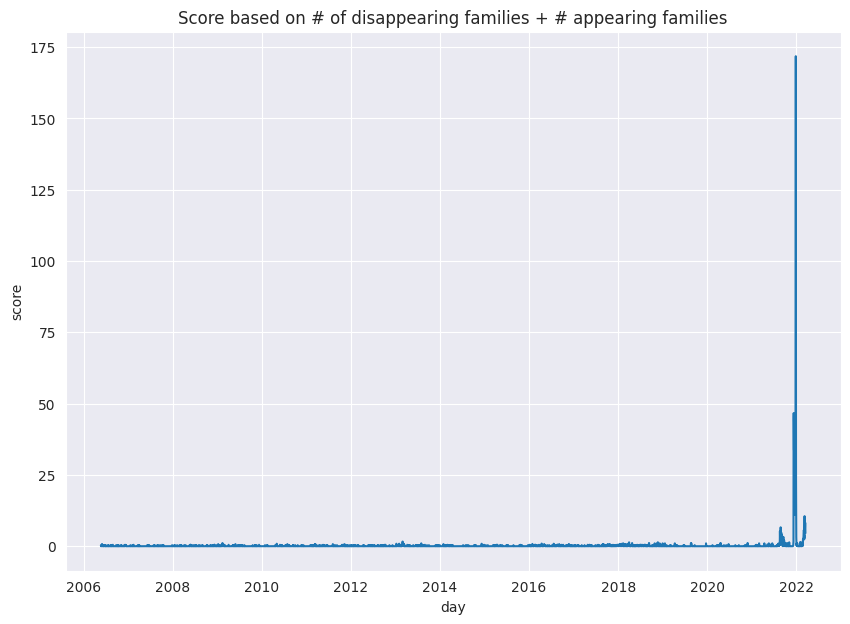

In [107]:
df_plot = pd.DataFrame({"day": days_range, "score": scores})
plt.figure(figsize=(10, 7))
sns.lineplot(data=df_plot, x="day", y="score")
plt.title(f"Score based on # of disappearing families + # appearing families")
plt.show()